# EDA

In [ ]:
# @title Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'cool-keel-393914' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=cool-keel-393914:US:bquxjob_fd8240a_189a1fb221a)
back to BigQuery to edit the query within the BigQuery user interface.

Lo primero que se debe realizar es determinar una main_cat, para ello, utilizamos varios jobs que he ido creando en mi espacio personal para enteder mejor los datos.

In [ ]:
job = client.get_job('bquxjob_1d52c2cd_189a3b94d23') # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT  am.main_cat, Count(ar.asin) as review_numbers, max(ar.overall) as max_overall, min(ar.overall) as min_overall, avg(ar.overall) as average_overall, stddev_samp(ar.overall) as standard_deviation, count(distinct ar.asin) as distinct_products, count(distinct ar.reviewerID) as distinct_reviewers
FROM `cool-keel-393914.02_process.amazon_reviews` AS ar LEFT JOIN (
  SELECT  am.main_cat, am.asin
  FROM `cool-keel-393914.02_process.amazon_metadata` AS am
  WHERE main_cat IS NOT NULL
) AS am ON am.asin = ar.asin
WHERE ar.vote IS NOT NULL
GROUP BY am.main_cat


In [ ]:
job = client.get_job('bquxjob_1d52c2cd_189a3b94d23') # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()
results

,main_cat,review_numbers,max_overall,min_overall,average_overall,standard_deviation,distinct_products,distinct_reviewers
0,GPS & Navigation,2493,5.0,1.0,3.574408,1.603749,709,2209
1,"<img src=""https://m.media-amazon.com/images/G/...",221,5.0,1.0,4.095023,1.434960,44,212
2,Fine Art,183,5.0,1.0,3.459016,1.771947,81,177
3,Car Electronics,32862,5.0,1.0,3.788418,1.521579,5298,26453
4,Industrial &amp; Scientific,1074,5.0,1.0,4.087523,1.418744,95,743
...,...,...,...,...,...,...,...,...
69,Entertainment,350,5.0,1.0,3.568571,1.689216,181,333
70,"<img src=""https://m.media-amazon.com/images/G/...",14885,5.0,1.0,4.270810,1.178373,2335,9698
71,Apple Products,105,5.0,1.0,2.685714,1.777608,5,105
72,Computers,173371,5.0,1.0,3.618529,1.614670,29552,147734


Existen mas de 70 categorias. En la consulta anterior, tenemos las siguientes columnas:

* reviews_numbers: numero de reviews
* max_overall: maxima puntuacion recibida
* min_overall: minima puntuacion recibida
* standard_deviation: desviacion estandar de la puntuacion recibida, se tomo la funcion como si fuese una muestra debido a que no necesariamente representa la poblacion
* distinct_products: numero de productos distintos que tienen esas reviews
* distinct_reviewers: numero distinto de personas que hicieron reviews

## Choose a main_cat



Un indicador util que nos puede ayudar a escoger, al menos, cuales de las siguientes categorias puede ser interesante para analizar, hallar KPIS, entre otros, puede ser la frecuencia de compra, este indica que tanto un mismo cliente, te compra varias veces el mismo producto.

Esto se puede calcular dividiendo el campo reviews_numbers entre distinct/reviewers. Adicional, esto se hara para aquellas categorias que tengan como minimo mas de 100 mil reviews

In [ ]:
import pandas as pd

df = pd.DataFrame(results[results['review_numbers']>=100000])
df['frequency'] = df['review_numbers']/df['distinct_reviewers']
df.sort_values(by = 'frequency', ascending = False)

,main_cat,review_numbers,max_overall,min_overall,average_overall,standard_deviation,distinct_products,distinct_reviewers,frequency
58,"<img src=""https://images-na.ssl-images-amazon....",1403577,5.0,1.0,4.302707,1.162146,227010,515203,2.724318
13,Movies & TV,1345611,5.0,1.0,3.858508,1.457390,97651,582838,2.308722
47,Books,10103326,5.0,0.0,4.063748,1.359966,1442264,4724620,2.138442
73,Video Games,368596,5.0,1.0,3.580250,1.560824,24519,194863,1.891565
43,Buy a Kindle,781793,5.0,1.0,4.030137,1.382113,186238,469428,1.665416
53,All Electronics,443179,5.0,1.0,3.487812,1.628030,41460,305170,1.452236
49,Camera & Photo,232013,5.0,1.0,3.863883,1.455561,25307,160597,1.444691
7,Software,121595,5.0,1.0,2.956931,1.713187,9598,86196,1.41068
23,None,130382,5.0,1.0,4.137879,1.313016,22440,92638,1.407435
61,Home Audio & Theater,243412,5.0,1.0,3.626962,1.566814,21670,176199,1.381461


 "Digital Music y Movies & TV" tienen la mayor frecuencia. Las cuales son de 2.72 y 2.32 respectivamente, lo que quiere decir, que un cliente es capaz de comprar productos de la misma categoria mas 2 veces en promedio y casi 3 veces en promedio.

 Estas dos categorias, se observara su distribucion por cada una de las

In [ ]:
main_cat = list(df[df['frequency']>=2.3]['main_cat'])
main_cat

['Movies & TV',
 '<img src="https://images-na.ssl-images-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png" class="nav-categ-image" alt="Digital Music"/>']

In [ ]:
in_sql = str(main_cat).replace('[','(').replace(']', ')')

query_job = client.query(f'''
SELECT  am.main_cat, ar.overall, Count(ar.asin) as review_numbers, count(distinct ar.asin) as distinct_products, count(distinct ar.reviewerID) as distinct_reviewers
FROM `cool-keel-393914.02_process.amazon_reviews` AS ar LEFT JOIN (
  SELECT  am.main_cat, am.asin
  FROM `cool-keel-393914.02_process.amazon_metadata` AS am
  WHERE main_cat IS NOT NULL
) AS am ON am.asin = ar.asin
WHERE ar.vote IS NOT NULL AND am.main_cat IN {in_sql}
GROUP BY am.main_cat, ar.overall
ORDER BY am.main_cat, ar.overall ASC
                         ''')
result_query = query_job.result()
data_frame = result_query.to_dataframe()
data_frame

,main_cat,overall,review_numbers,distinct_products,distinct_reviewers
0,"<img src=""https://images-na.ssl-images-amazon....",1.0,86063,24680,50057
1,"<img src=""https://images-na.ssl-images-amazon....",2.0,60699,24711,34965
2,"<img src=""https://images-na.ssl-images-amazon....",3.0,101218,43634,48074
3,"<img src=""https://images-na.ssl-images-amazon....",4.0,249919,92295,98289
4,"<img src=""https://images-na.ssl-images-amazon....",5.0,905678,186856,384445
5,Movies & TV,1.0,187890,32523,116703
6,Movies & TV,2.0,93120,26679,52409
7,Movies & TV,3.0,130995,37275,65274
8,Movies & TV,4.0,243094,51172,111302
9,Movies & TV,5.0,690512,74702,350243


Estos resultados se observan mejor en un grafico

In [ ]:
x =  '<img src="https://images-na.ssl-images-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png" class="nav-categ-image" alt="Digital Music"/>'

In [ ]:
from bs4 import BeautifulSoup

def obtain_cat(x:str) -> str:
  if 'img' in x:
    soup = BeautifulSoup(x, 'html.parser')
    img = soup.find_all('img')
    return img[0]['alt']
  else:
    return x

data_frame['main_cat'] = data_frame['main_cat'].apply(obtain_cat)
data_frame

,main_cat,overall,review_numbers,distinct_products,distinct_reviewers
0,Digital Music,1.0,86063,24680,50057
1,Digital Music,2.0,60699,24711,34965
2,Digital Music,3.0,101218,43634,48074
3,Digital Music,4.0,249919,92295,98289
4,Digital Music,5.0,905678,186856,384445
5,Movies & TV,1.0,187890,32523,116703
6,Movies & TV,2.0,93120,26679,52409
7,Movies & TV,3.0,130995,37275,65274
8,Movies & TV,4.0,243094,51172,111302
9,Movies & TV,5.0,690512,74702,350243


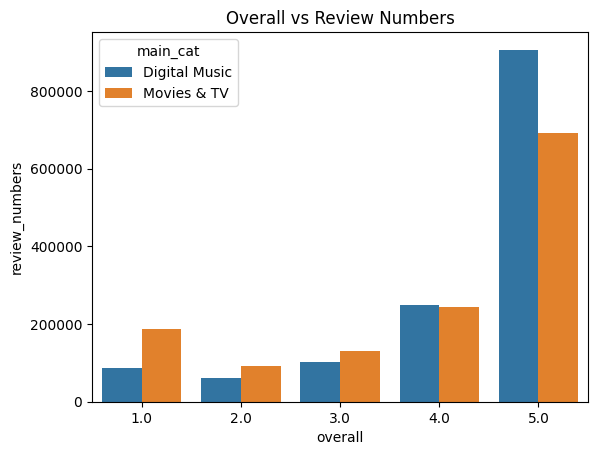

In [ ]:
import seaborn as sns

fig = sns.barplot(data_frame, x = 'overall', y = 'review_numbers', hue='main_cat').set(title='Overall vs Review Numbers')

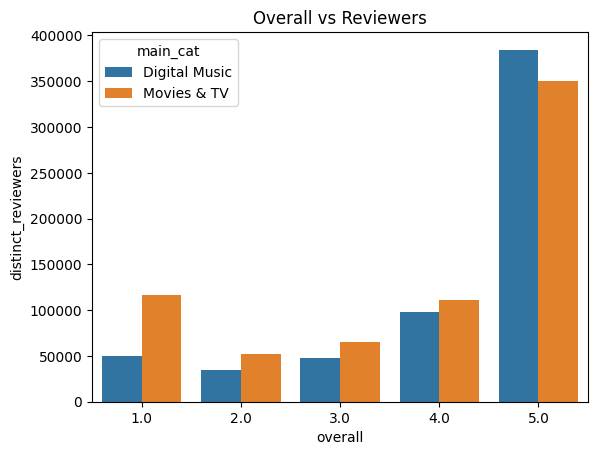

In [ ]:
fig = sns.barplot(data_frame, x = 'overall', y = 'distinct_reviewers', hue='main_cat').set(title='Overall vs Reviewers')

Entre las dos categorias, lo mejor es escoger Digital Music, ya que tiene la mayor variedad en cuanto a reviews.